In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torchvision

!cp "/content/drive/My Drive/lib/datasets.py" .
!cp "/content/drive/My Drive/lib/autoencoder.py" .
!cp "/content/drive/My Drive/lib/cnn.py" .
!cp "/content/drive/My Drive/lib/vae.py" .
!cp "/content/drive/My Drive/lib/utils.py" .

import datasets
import autoencoder
import cnn
import vae
import utils

torch.cuda.set_device(0)

## Load MNIST data using `dataset.py`



In [3]:
trn_dset, tst_dset = datasets.get_mnist_dataset(trn_size=60000, tst_size=10000)
trn_loader, tst_loader = datasets.get_cifar_loader(trn_dset, tst_dset, batch_size=128)
inputs,targets = next(iter(trn_loader))
inputs.size()

torch.Size([128, 1, 28, 28])

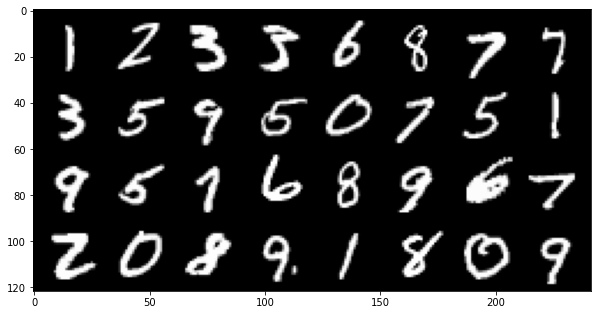

Train: 60000 Test: 10000 Input: torch.Size([128, 1, 28, 28]) Target: torch.Size([128])


In [4]:
utils.plot_batch(inputs[:32])
print("Train:", len(trn_loader.dataset), "Test:", len(tst_loader.dataset), 
      "Input:", inputs.size(), "Target:", targets.size())

## Train `CNN`-based digit recognizer using `cnn.py`

In [5]:
model = cnn.CNN(in_shape=(1,28,28), n_classes=10).cuda()

In [6]:
epochs = 10
iters = epochs * len(trn_loader)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
lr_adjuster = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
trainer = cnn.Trainer(optimizer, lr_adjuster)

In [7]:
trainer.run(model, trn_loader, tst_loader, criterion, epochs)

/content/cnn.py:105: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs = Variable(data[0].cuda(), volatile=True)


Epoch 1, TrnLoss: 1.528, TrnAcc: 0.970, TstLoss: 1.479, TstAcc: 0.990
Epoch 2, TrnLoss: 1.481, TrnAcc: 0.989, TstLoss: 1.473, TstAcc: 0.993
Epoch 3, TrnLoss: 1.476, TrnAcc: 0.993, TstLoss: 1.473, TstAcc: 0.993
Epoch 4, TrnLoss: 1.473, TrnAcc: 0.995, TstLoss: 1.471, TstAcc: 0.994
Epoch 5, TrnLoss: 1.470, TrnAcc: 0.996, TstLoss: 1.469, TstAcc: 0.995
Epoch 6, TrnLoss: 1.469, TrnAcc: 0.997, TstLoss: 1.469, TstAcc: 0.994
Epoch 7, TrnLoss: 1.468, TrnAcc: 0.998, TstLoss: 1.469, TstAcc: 0.995
Epoch 8, TrnLoss: 1.468, TrnAcc: 0.998, TstLoss: 1.469, TstAcc: 0.994
Epoch 9, TrnLoss: 1.467, TrnAcc: 0.998, TstLoss: 1.469, TstAcc: 0.994
Epoch 10, TrnLoss: 1.467, TrnAcc: 0.998, TstLoss: 1.469, TstAcc: 0.995


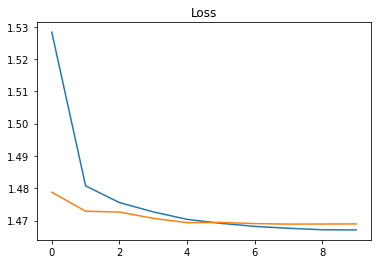

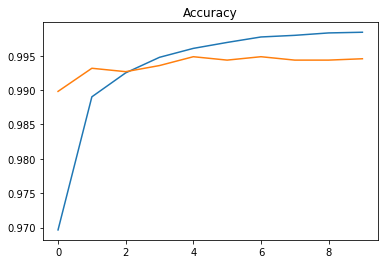

In [8]:
utils.plot_metric(trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst'], 'Loss')
utils.plot_metric(trainer.metrics['accuracy']['trn'], trainer.metrics['accuracy']['tst'], 'Accuracy')

## Build a `VQ-VAE-2` model using `vqvae.py`

In [9]:
model = vae.VAE(in_shape=(1,28,28), n_latent=100).cuda()

In [10]:
criterion = nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


/content/vae.py:118: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs = Variable(inputs.cuda(), volatile=True)


Epoch 1, TrnLoss: 1952.0242, TstLoss: 603.9067


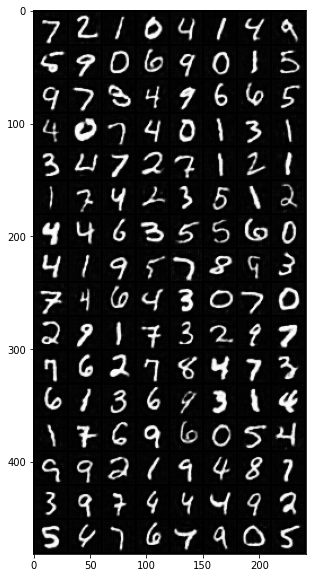

Epoch 2, TrnLoss: 532.9825, TstLoss: 481.4479
Epoch 3, TrnLoss: 464.8553, TstLoss: 441.5085
Epoch 4, TrnLoss: 432.9289, TstLoss: 416.3665
Epoch 5, TrnLoss: 414.4189, TstLoss: 407.2488
Epoch 6, TrnLoss: 401.4436, TstLoss: 402.2969


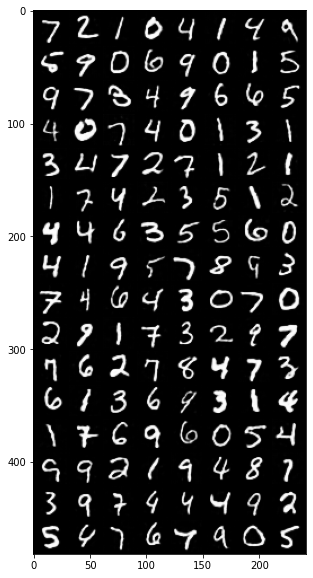

Epoch 7, TrnLoss: 391.9207, TstLoss: 390.0497
Epoch 8, TrnLoss: 383.1121, TstLoss: 377.6371
Epoch 9, TrnLoss: 377.7257, TstLoss: 374.2517
Epoch 10, TrnLoss: 372.6261, TstLoss: 370.3044


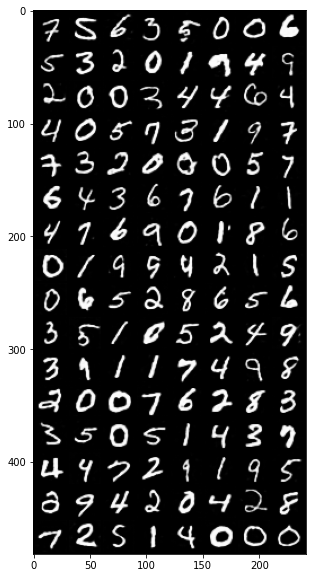

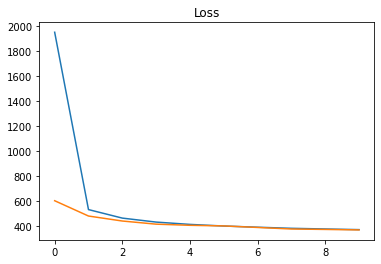

In [11]:
losses = vae.run(model, trn_loader, tst_loader, criterion, 
                 optimizer, epochs=10, plot_interval=5)
utils.plot_metric(losses['trn'], losses['tst'], 'Loss')

In [12]:
# Single Image
img_idx = 1
noise = 1. + torch.randn(1) * 1e-1 
inputs,targs=next(iter(tst_loader))
recon, mean, var = vae.predict(model, inputs[img_idx])
out = vae.generate(model, mean*noise, var*noise)

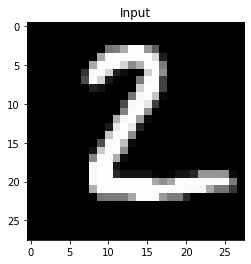

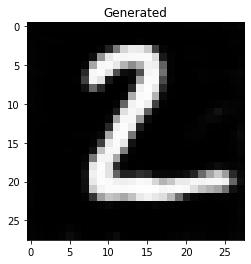

In [13]:
utils.plot_batch(inputs[img_idx], title="Input", fs=(4,4)) 
utils.plot_batch(out, title="Generated", fs=(4,4))

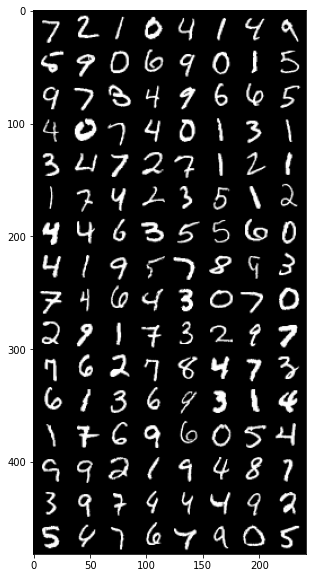

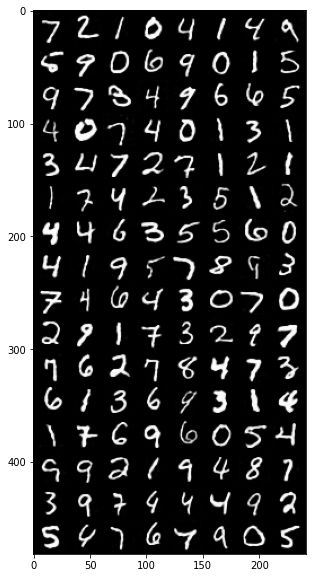

In [14]:
# Batch
recon, mean, var = vae.predict(model, inputs)
out = vae.generate(model, mean, var)
utils.plot_batch(inputs)
utils.plot_batch(out)

## Perform feature space augmentation using the `VQ-VAE-2`

In [15]:
augmentor = model
classifier = cnn.CNN(in_shape=(1,28,28), n_classes=10).cuda()

In [16]:
epochs = 10
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_adjuster = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
trainer = cnn.Trainer(optimizer, lr_adjuster, augmentor)

In [17]:
trainer.run(classifier, trn_loader, tst_loader, criterion, epochs)

/content/cnn.py:105: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs = Variable(data[0].cuda(), volatile=True)


Epoch 1, TrnLoss: 1.530, TrnAcc: 0.966, TstLoss: 1.475, TstAcc: 0.990
Epoch 2, TrnLoss: 1.479, TrnAcc: 0.988, TstLoss: 1.472, TstAcc: 0.991
Epoch 3, TrnLoss: 1.474, TrnAcc: 0.991, TstLoss: 1.469, TstAcc: 0.994
Epoch 4, TrnLoss: 1.471, TrnAcc: 0.994, TstLoss: 1.468, TstAcc: 0.995
Epoch 5, TrnLoss: 1.469, TrnAcc: 0.995, TstLoss: 1.468, TstAcc: 0.994
Epoch 6, TrnLoss: 1.468, TrnAcc: 0.996, TstLoss: 1.468, TstAcc: 0.995
Epoch 7, TrnLoss: 1.467, TrnAcc: 0.996, TstLoss: 1.468, TstAcc: 0.995
Epoch 8, TrnLoss: 1.467, TrnAcc: 0.997, TstLoss: 1.467, TstAcc: 0.996
Epoch 9, TrnLoss: 1.466, TrnAcc: 0.997, TstLoss: 1.467, TstAcc: 0.996
Epoch 10, TrnLoss: 1.466, TrnAcc: 0.997, TstLoss: 1.467, TstAcc: 0.996


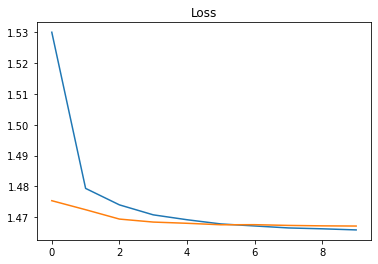

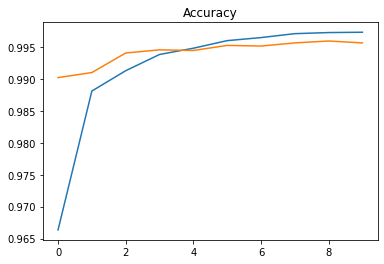

In [18]:
utils.plot_metric(trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst'], 'Loss')
utils.plot_metric(trainer.metrics['accuracy']['trn'], trainer.metrics['accuracy']['tst'], 'Accuracy')